# ABS Inflation multi-measure

## Python set-up

In [1]:
# system imports
import sys
from pathlib import Path

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
from abs_data_capture import (
    get_ABS_meta_and_data, 
    get_fs_constants,
    get_meta_constants,
    find_id,
)
from plotting import (
    clear_chart_dir, 
    line_plot,
    set_chart_dir
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
SHOW = True

## Get data from ABS

In [2]:
# ABS data extraction settings
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

In [3]:
abs_data = {} 
def get_abs(catalogue_id: str) -> dict:
    
    if catalogue_id not in abs_data:
        abs_dict = get_ABS_meta_and_data(catalogue_id)
        if abs_dict is None:
            sys.exit(-1)
        abs_data[catalogue_id] = abs_dict
        return abs_dict
    
    return abs_data[catalogue_id]

In [4]:
sources = set()
def get_series(
    catalogue_id: str, table: str, series_type: str, did_type: str, series_name: str
) -> pd.Series:
    
    # get the ABS data
    data_dict = get_abs(catalogue_id)
    sources.add(catalogue_id)
    _, _, META_DATA = get_fs_constants(catalogue_id)
    meta = data_dict[META_DATA]
    data = data_dict[table]
    
    # get the identified series
    search_terms = {
        table: table_col,
        "Seasonally Adjusted" if series_type == "SA" else "Original": type_col,
        did_type: did_col,
        series_name: did_col,
    }
    series_id, _ =  find_id(meta, search_terms, verbose=True)
    series = data[series_id]
    
    return series

In [5]:
def calculate_growth(series, name, summary):
    
    period = series.index.freqstr[0]
    shift = 4 if period == "Q" else 12 if period == "M" else 0
    if not shift:
        print(f"--- Something odd---: {name} {series.index.freqstr}")
    growth = series.pct_change(periods=shift) * 100
    if period == 'Q':
        growth = growth.resample("M", convention="end").mean()
    return growth

In [6]:
capture = {
    # specify the data items we wish to capture ...
    # raw data - we will calculate growth from index numbers/etc.
    # description: [catalogue_id, table, series_type, did_type, series_name, summary]
    "All Groups CPI": ["6401", "2", "Orig", "Index Numbers", "All groups CPI ;  Australia ;", "CPI"],
    "CPI Trimmed Mean": ["6401", "8", "SA", "Index Numbers", "Trimmed Mean ;  Australia ;", "CPI-TM"],
    "Monthly CPI Indicator": ["6484", "1", "SA", "Index Numbers", "All groups CPI, seasonally adjusted ;  Australia", "M-CPI"],

    "Producer Price Index": ["6427", "1", "Orig", "Index Numbers", "Final ;  Total ", "PPI"],
    "Wage Price Index": ["6345", "1", "SA", "Quarterly Index", "Total hourly rates of pay excluding bonuses ;  Australia ;  Private and Public ;  All industries ;", "WPI"],
    
    "GDP Price Deflator": ["5206", "5", "SA", " ", "GROSS DOMESTIC PRODUCT ;", "GDP"],
    "Household consumption Price Deflator": ["5206", "5", "SA", " ", "Households ;  Final consumption expenditure ;", "HFCE"],
    "Non-farm hourly employee compensation": ["5206", "24", "SA", "Current prices ;", "Non-farm compensation of employees per hour:", "NFHEC"],
    
    #"All groups CPI": ["6401", "8", "SA", "Index Numbers", "All groups CPI, seasonally adjusted ;  Australia ;", "CPISA"],
    #"Hourly employee compensation": ["5206", "24", "SA", "Current prices ;", "Compensation of employees per hour", "HEC"],
}

# let's download the ABS data
combined = {}
latest = []
for name, (catalogue_id, table, series_type, did_type, series_name, summary) in capture.items():

    series = get_series(catalogue_id, table, series_type, did_type, series_name)
    growth = calculate_growth(series, name, summary)
    full_name = f"{name} ({series_type})"
    growth.name = full_name
    combined[full_name] = growth
    latest.append(f"{summary}={round(growth.dropna().iloc[-1], 1)}")

frame = pd.DataFrame(combined)
source = f"ABS {', '.join(sorted(sources))}"
latest = f"Latest reported: {', '.join(latest)}."
print("\n", latest)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...

 Latest reported: CPI=7.0, CPI-TM=6.6, M-CPI=6.5, PPI=5.2, WPI=3.3, GDP=9.1, HFCE=6.9, NFHEC=2.9.


## Plot the data

In [7]:
# plot settings
CHART_DIR = "./CHARTS/Inflation"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")

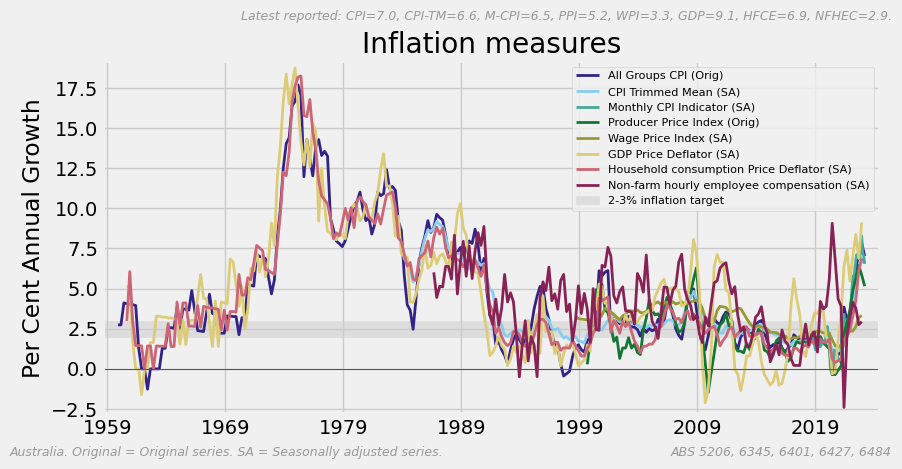

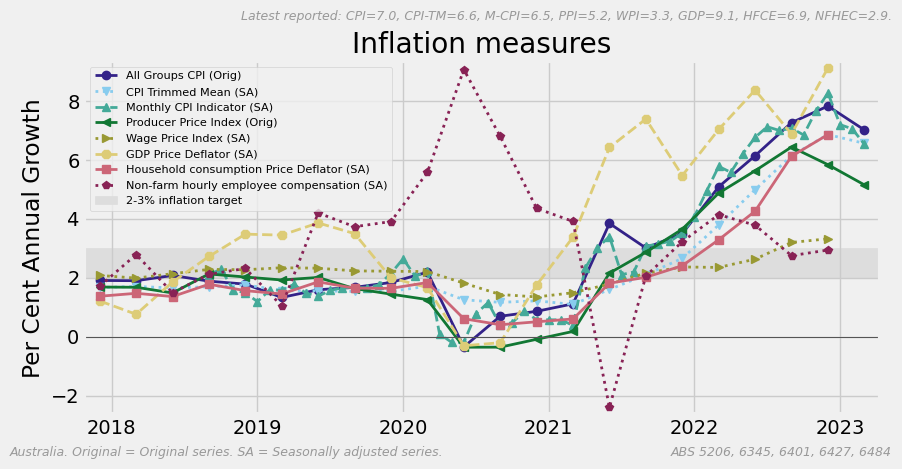

In [8]:
target = {
    "ymin": 2,
    "ymax": 3,
    "color": "#dddddd",
    "label": "2-3% inflation target",
    "zorder": -1,
}
starts = ("1959-11-01", "2017-11-01")
styles = (None, ["solid", "dotted", "dashed"] * 3)
markers = (None, ['o', 'v', '^', '<', '>', '8', 's', 
                  'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])

for start, style, marker in zip(starts, styles, markers):

    line_plot(
        frame,
        starts=start,
        style=style,
        marker=marker,
        markersize=6,
        dropna=True, 
        title="Inflation measures",
        ylabel="Per Cent Annual Growth",
        legend={"fontsize": "xx-small"},
        axhspan=target,
        y0=True,
        rfooter=source,
        lfooter="Australia. Original = Original series. SA = Seasonally adjusted series. ",
        rheader=latest if start is not None else None,
        tags=start if start is not None else '',
        show=SHOW,
    )

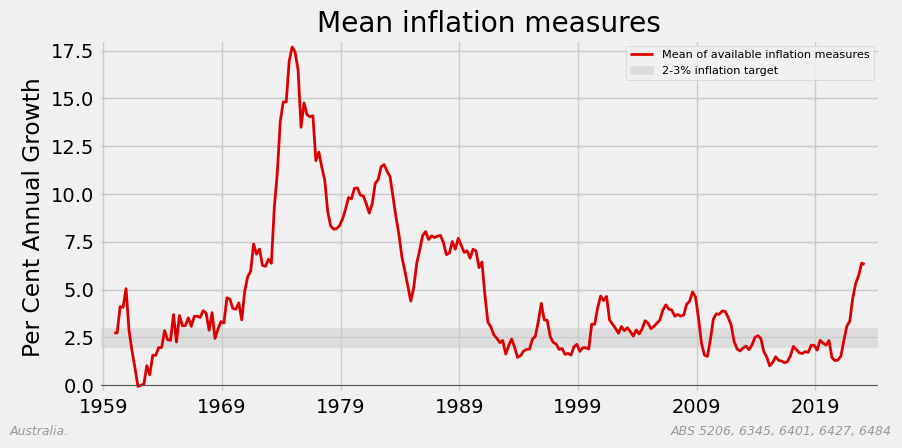

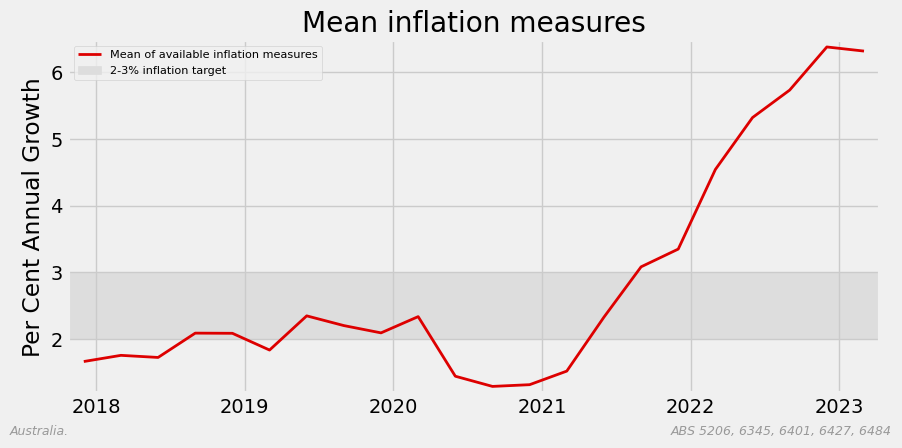

In [9]:
# Not sure this is really meaningful, or comparable over time.

# Calculate mean for quarters only
mean_inflation = (
    frame
    .loc[frame.index.month.isin((3, 6, 9, 12))]
    .mean(axis=1)
)
mean_inflation.name = "Mean of available inflation measures"

# plot
for start in starts:
    line_plot(
        mean_inflation,
        starts=start,
        title="Mean inflation measures",
        ylabel="Per Cent Annual Growth",
        legend={"fontsize": "xx-small"},
        axhspan=target,
        y0=True,
        rfooter=source,
        lfooter="Australia. ",
        tags=start if start is not None else '',
        show=SHOW,
    )

## Phillips curves

In [10]:
capture = {
    "All Groups CPI": ["6401", "2", "Orig", "Index Numbers", "All groups CPI ;  Australia ;", "CPI"],
    
}

## Finished

In [11]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat May 13 2023 14:06:29

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

matplotlib: 3.7.1
pandas    : 2.0.1
sys       : 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]

Watermark: 2.3.1



In [12]:
print("Finished")

Finished
